<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/accent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
!pip install soundfile

In [0]:
import soundfile as sf
import zipfile
import sys
from os import path, listdir

base = 'My Drive'

zipfile.ZipFile(path.join(base, 'speech-accent-archive.zip')).extractall('..')
listdir()

['My Drive', '.Trash']

In [0]:
!ls ../recordings/recordings | grep 'english' | head

english100.mp3
english101.mp3
english102.mp3
english103.mp3
english104.mp3
english105.mp3
english106.mp3
english107.mp3
english108.mp3
english109.mp3


In [0]:
!head ../speakers_all.csv

age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,,,
24,12,"koussi, senegal",balanta,balanta,male,788,senegal,TRUE,,,
18,10,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,TRUE,,,
48,8,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,TRUE,,,
42,42,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,TRUE,,,
40,35,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,TRUE,,,
43,41,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,TRUE,,,
21,21,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,TRUE,,,
54,51,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,TRUE,,,
18,16,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,TRUE,,,


In [0]:
!wc -l ../speakers_all.csv

2173 ../speakers_all.csv


In [0]:
import pandas as pd


df = pd.read_csv('../speakers_all.csv')
df = df[df['file_missing?'] == False]
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,NaN,NaN,NaN
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,NaN,NaN,NaN
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,NaN,NaN,NaN
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,NaN,NaN,NaN
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,NaN,NaN,NaN


In [0]:
df['target'] = [f'{row.sex}-{row.country}-{row.native_language}' for i, row in df.iterrows() ]

In [0]:
from collections import Counter

Counter(df.target).most_common(50)

[('male-usa-english', 189),
 ('female-usa-english', 184),
 ('male-uk-english', 41),
 ('female-china-mandarin', 33),
 ('male-canada-english', 27),
 ('female-south korea-korean', 27),
 ('female-uk-english', 24),
 ('male-south korea-korean', 23),
 ('male-saudi arabia-arabic', 22),
 ('male-italy-italian', 22),
 ('male-turkey-turkish', 21),
 ('female-belgium-dutch', 20),
 ('male-brazil-portuguese', 20),
 ('male-china-mandarin', 19),
 ('female-brazil-portuguese', 19),
 ('male-australia-english', 18),
 ('male-poland-polish', 18),
 ('female-canada-english', 17),
 ('female-japan-japanese', 17),
 ('female-macedonia-macedonian', 17),
 ('female-germany-german', 16),
 ('female-poland-polish', 16),
 ('female-china-cantonese', 14),
 ('female-australia-english', 14),
 ('male-france-french', 14),
 ('male-russia-russian', 14),
 ('female-turkey-turkish', 14),
 ('female-france-french', 13),
 ('female-russia-russian', 13),
 ('female-colombia-spanish', 13),
 ('male-vietnam-vietnamese', 13),
 ('male-bolivia-

In [0]:
accents, counts = zip(*Counter(df.target).most_common(10))
accents

('male-usa-english',
 'female-usa-english',
 'male-uk-english',
 'female-china-mandarin',
 'male-canada-english',
 'female-south korea-korean',
 'female-uk-english',
 'male-south korea-korean',
 'male-saudi arabia-arabic',
 'male-italy-italian')

In [0]:
from os import path
from glob import glob
import librosa 
import numpy as np         
from tqdm.auto import tqdm
 
base = '../recordings/recordings'
x = []
y = []

for t, accent in enumerate(accents):
  for fpath in tqdm(df[df['target']==accent].filename.values):
    sound, rate = librosa.load(path.join(base, f'{fpath}.mp3')) 
    n = len(sound)
    chunksize = 22050*2
    for i in range(0, n-chunksize, chunksize):
      x.append (np.abs(librosa.stft(sound[i:i+chunksize], n_fft=1024, hop_length=512)).T)
      y.append(t)

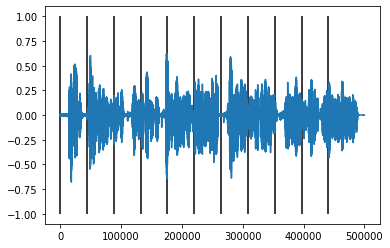

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sound)
plt.vlines([i for i in range(0, len(sound)-chunksize, chunksize)], -1, 1)

In [0]:
len(x), len(y)

(7043, 7043)

In [0]:
from collections import Counter

Counter(y)

Counter({0: 2049,
         1: 2024,
         2: 446,
         3: 542,
         4: 287,
         5: 412,
         6: 267,
         7: 342,
         8: 388,
         9: 286})

In [0]:
from sklearn.model_selection import train_test_split
import torch

x1 = np.stack(x)
y1 = np.stack(y)

x_train, x_test, y_train, y_test = train_test_split(x1, y1, stratify=y1)

train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)

test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test, batch_size = 128, shuffle=True)

In [0]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.auto import tqdm

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden_size = 128
    self.num_layers = 2
    self.lstm =  nn.LSTM(513, self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.linear = nn.Linear(self.num_layers * self.hidden_size, len(accents))

  def forward(self, x):
    h_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    
    h_lstm, _ = self.lstm(x, (h_t, c_t))
    # print (h_lstm.shape)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat(( avg_pool, max_pool), 1)
    # print (conc.shape)
    encoded = self.linear(conc).view(-1, len(accents))
    return encoded
    # return torch.softmax(encoded, 1)

import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


net = Net()
net.apply(weight_init)
net(torch.from_numpy(np.stack(x[0:10])))

tensor([[ 0.8391,  0.7493, -1.1947, -0.2097, -1.0989,  0.3164,  2.0995, -0.0464,
          1.7963,  2.9610],
        [ 0.8725,  0.7606, -1.1818, -0.2880, -1.1163,  0.2796,  2.1015, -0.0242,
          1.7516,  2.9557],
        [ 0.8454,  0.7108, -1.2223, -0.2318, -1.0808,  0.3241,  2.0848, -0.0410,
          1.7796,  2.9831],
        [ 0.8307,  0.6843, -1.1667, -0.1984, -1.0318,  0.3527,  2.1289, -0.0456,
          1.8202,  2.9785],
        [ 0.8243,  0.7604, -1.1035, -0.2536, -1.0537,  0.3193,  2.1035, -0.0047,
          1.7235,  2.9909],
        [ 0.7889,  0.7338, -1.1441, -0.1838, -1.0766,  0.3205,  2.0961, -0.0353,
          1.8345,  2.9044],
        [ 0.8136,  0.7672, -1.1965, -0.2683, -1.0942,  0.2894,  2.0811, -0.0560,
          1.8019,  2.9586],
        [ 0.7712,  0.7433, -1.1118, -0.1844, -1.0461,  0.2836,  2.1462, -0.0266,
          1.7415,  2.9390],
        [ 0.8719,  0.7294, -1.2070, -0.2674, -1.1276,  0.3067,  2.0971, -0.0317,
          1.7578,  3.0096],
        [ 0.8295,  

In [0]:
Counter(y_test)

Counter({0: 512,
         1: 506,
         2: 112,
         3: 136,
         4: 72,
         5: 103,
         6: 67,
         7: 85,
         8: 97,
         9: 71})

In [0]:
c = Counter(y_train)
weights = []
for i in range(10):
  weights.append(1/c[i])
weights = np.array(weights)
weights = weights / np.sum(weights)
weights

array([0.02, 0.02, 0.09, 0.08, 0.15, 0.1 , 0.16, 0.12, 0.11, 0.15])

In [0]:
net = Net()
net.apply(weight_init)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

for _ in range(10):
  train_losses = []
  train_scores = []
  for inputs, targets in tqdm(train_loader):
    optimizer.zero_grad()
    output = net(inputs)
    p = torch.argmax(torch.softmax(output, 1), 1)
    score = torch.mean((p == targets).float())
    train_scores.append(score)
    loss = criterion(output, targets)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
  print ('Train loss =', np.mean(train_losses))
  print ('Train score =', np.mean(train_scores))

  with torch.no_grad():
    test_scores = []
    for inputs, targets in tqdm(test_loader):
      
      output = net(inputs)

      p = torch.argmax(torch.softmax(output, 1), 1)
      score = torch.mean((p == targets).float())
      test_scores.append(score.item())
    print ('Test score =', np.mean(test_scores), end='\n\n')

Train loss = 2.235191646076384
Train score = 0.16068146


Test score = 0.19593381775277002



Train loss = 1.7205384174982707
Train score = 0.24332546


Test score = 0.3131845997912543



Train loss = 1.5095121292840867
Train score = 0.34029236


Test score = 0.3401486554316112



Train loss = 1.343508439404624
Train score = 0.39884236


Test score = 0.41932069190910887



Train loss = 1.1682939813250588
Train score = 0.44587055


Test score = 0.4217311761208943



Train loss = 1.0467852864946638
Train score = 0.5007769


Test score = 0.44465666370732443



Train loss = 0.9229636774176643
Train score = 0.5600928


Test score = 0.4482925257512501



Train loss = 0.7587681668145316
Train score = 0.61133355


Test score = 0.5284483134746552



Train loss = 0.6595822629474458
Train score = 0.65388656


Test score = 0.5209924961839404



Train loss = 0.5624551389898572
Train score = 0.7021512


Test score = 0.5269525476864406



[512. 506. 112. 136.  72. 103.  67.  85.  97.  71.]


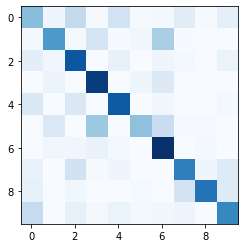

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=2)

with torch.no_grad():
  p = torch.argmax(net(torch.from_numpy(x_test)), 1).int().numpy()

cm = confusion_matrix(y_test, p).astype(float)
print(cm.sum(axis=1))
for i in range(10):
  cm[i] /= cm[i].sum()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)